In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import mediapipe as mp

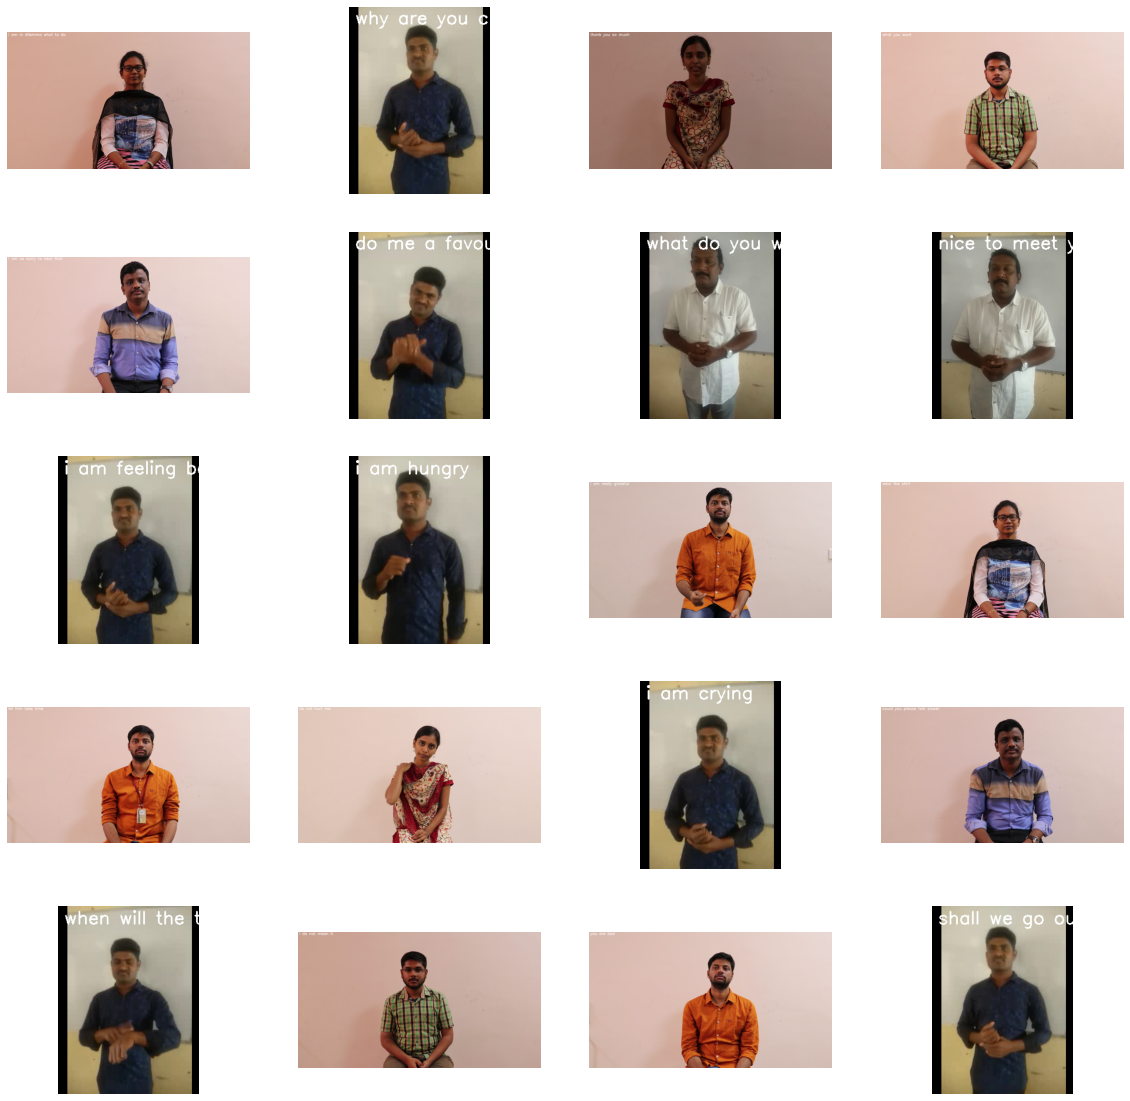

In [4]:
#Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize = (20,20))

#Get the names of all classes/categories in UCF50
all_classes_names = os.listdir('Videos_Sentence_Level')

#Generate a list of 20 random values. The values will be between 0-50
#Where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

#Iterating through all the generated random values.
for counter,random_index in enumerate(random_range,1):
    selected_class_Name = all_classes_names[random_index]
    
    video_files_names_list = os.listdir(f'Videos_Sentence_Level/{selected_class_Name}')
    
    selected_video_file_name = random.choice(video_files_names_list)
    
    video_reader = cv2.VideoCapture(f'Videos_Sentence_Level/{selected_class_Name}/{selected_video_file_name}')
    
    _,bgr_frame = video_reader.read()
    
    video_reader.release()
    
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Preprocess the data

In [5]:
#Specify the height and width to which each video frame will be resized in our dataset
img_height, img_width = 96, 96

#Specify the number of frames of a video that will be fed to the model as one sequence
sequence_length = 20

#Specify the directory containing the Videos_Sentence_Level dataset
data_dir = 'Videos_Sentence_Level'

#Specify the list containg the names of the classes used for training. Feel free to chooseany set of classes
#classes_list = os.listdir(data_dir)
classes_list = ['are you free today', 'are you hiding something', 'bring water for me', 'can i help you',
                'can you repeat that please', 'comb your hair', 'congratulations', 'could you please talk slower',
                'do me a favour', 'do not abuse him',]
classes_list

['are you free today',
 'are you hiding something',
 'bring water for me',
 'can i help you',
 'can you repeat that please',
 'comb your hair',
 'congratulations',
 'could you please talk slower',
 'do me a favour',
 'do not abuse him']

### Creating a function to Extract, Resize and Normalize Frames

In [6]:
'''
This function will extract the required frames from a video after resizing and normalizing them.
Args:
    video_path: The path of the video in the disk whose frames are to be executed.
Returns:
    frames_list: A list containing the resized and normalized frames of the video.
'''
def frames_extraction(video_path):
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
    
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)
    
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window+10)
        
        success, frame = video_reader.read()
        
        if not success:
            break
            
        
        resized_frame = cv2.resize(frame, (img_height, img_width))
        
        normalized_frame = resized_frame/255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()
    
    return frames_list

### Create a Function for Dataset Creation
Now we will create a function create_dataset() that will iterate through all the classes specified in the CLASSES_LIST constantand will call the function frame_extraction() on every video file of the selected classes and return the ferames (features), class index(labels), and video file path (video_files_paths).

In [7]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    
    features = []
    labels = []
    video_files_paths =[]
    
    for class_index, class_name in enumerate(classes_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        #Iterate through all the files present in the files list.
        for file_name in files_list:
            
            #Get the complete video path
            video_file_path = os.path.join(data_dir, class_name, file_name) 
            
            #Extract the frames of the video file
            frames = frames_extraction(video_file_path)
            
            #Check if the extracted frames are equal to the sequence_length specified above
            #So ignore the videos having frames less than the sequence_length
            if len(frames) == sequence_length:
                
                #Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                
    #Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    
    #Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset.

In [8]:
#Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: are you free today
Extracting Data of Class: are you hiding something
Extracting Data of Class: bring water for me
Extracting Data of Class: can i help you
Extracting Data of Class: can you repeat that please
Extracting Data of Class: comb your hair
Extracting Data of Class: congratulations
Extracting Data of Class: could you please talk slower
Extracting Data of Class: do me a favour
Extracting Data of Class: do not abuse him


In [9]:
#Using Kera's to categorical method to convert labels into one_hot_encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## 3. Split the Data into Train and Test Set
As of now, we have the required features (a NumPy array containning all the extracted frames of the videos) and one_hot_encoded_labels (also a NumPy array containing all class labels in onehot encoded format). So now, we will split our data to create and training sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [10]:
#Split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.3, random_state = 42,
                                                   stratify = one_hot_encoded_labels)

Text(0.5, 1.0, '0.0')

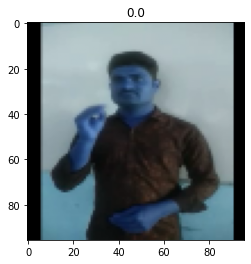

In [11]:
plt.imshow(x_train[0][10])
plt.title(y_train[0][0])

In [17]:
x_train.shape

(37, 20, 96, 96, 3)

## 4. Implement the ConvLSTM approach

In [12]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Conv2D, LSTM, Input, GlobalAveragePooling3D
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from keras.layers import TimeDistributed

In [38]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
    
    #We will use a Sequential model for model construction
    model = Sequential()
    
    #Define the model architecture
    #---------------------------------------------------------------------------------------------------
    
    #First block
    model.add(ConvLSTM2D(filters = 64, kernel_size = (3,3), activation = 'relu', data_format='channels_last',
                         return_sequences = True, input_shape = (sequence_length, img_height, img_width, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(1,2, 2), data_format='channels_last'))
    model.add(Dropout(0.1))
    
    #Second block
    model.add(ConvLSTM2D(filters = 64, kernel_size = (3,3), activation = 'relu', return_sequences = True))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(1, 2, 2), data_format='channels_last'))
    model.add(Dropout(0.2))
    
    #Third block
    model.add(ConvLSTM2D(filters = 128, kernel_size = (3,3), activation = 'relu', return_sequences = True))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(1, 2, 2), data_format='channels_last'))
    model.add(Dropout(0.2))
    
    #Fourth block
    model.add(ConvLSTM2D(filters = 128, kernel_size = (3,3), activation = 'relu', return_sequences = True))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool3D(pool_size=(1, 2, 2), data_format='channels_last'))
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling3D())
    
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 96, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = len(classes_list), activation = 'softmax'))
    
    #Display the model    
    model.summary()
    
    #Return the constructed convlstm model
    return model  

In [25]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
    
    #We will use a Sequential model for model construction
    model = Sequential()
    
    #Define the model architecture
    #---------------------------------------------------------------------------------------------------
    
    model.add(LSTM2D(64, return_sequences=True, activation='swish', input_shape=(20,96,96,3)))
    model.add(LSTM2D(128, return_sequences=True, activation='swish'))
    model.add(LSTM2D(64, return_sequences=False, activation='swish'))
    model.add(Dense(64, activation='swish'))
    model.add(Dense(32, activation='swish'))
    model.add(Dense(len(classes_list), activation='softmax'))
    
    #Display the model    
    model.summary()
    
    #Return the constructed convlstm model
    return model  

In [26]:
#Construct the required convlstm model
convlstm_model = create_convlstm_model()

#Display the success model
print('Model created succesfully')

NameError: name 'LSTM2D' is not defined

### Check Model's Taining

In [20]:
convlstm_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [21]:
#early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model/sign_language.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)
callback = [checkpoint, reduce_lr, earlystop]

In [22]:
cnn_model = convlstm_model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 50, 
                      validation_split = 0.3, shuffle = True, callbacks = callback)

Epoch 1/50


ValueError: in user code:

    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\KIIT\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: (None, 20, 96, 96, 3)


## 5. Using the LRCN Approach
### Construct the model

In [36]:
def LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
    
    input = Input(shape = (sequence_length, img_height, img_width, 3))
    
    #Define the Model Architecture
    #---------------------------------------------------------------------------------------------------
    #First Block
    c1 = TimeDistributed(Conv2D(filters = 32, kernel_size = (3,3), activation = 'swish', padding = 'same'))(input)
    b1 = TimeDistributed(BatchNormalization())(c1)
    m1 = TimeDistributed(MaxPool2D(pool_size=(2, 2)))(b1)
    d1 = TimeDistributed(Dropout(0.2))(m1)
    
    #Second Block
    c2 = TimeDistributed(Conv2D(filters = 64, kernel_size = (3,3), activation = 'swish', padding = 'same'))(d1)
    b2 = TimeDistributed(BatchNormalization())(c2)
    m2 = TimeDistributed(MaxPool2D(pool_size=(2, 2)))(b2)
    d2 = TimeDistributed(Dropout(0.2))(m2)
    
    #Third Block
    c3 = TimeDistributed(Conv2D(filters = 128, kernel_size = (3,3), activation = 'swish', padding = 'same'))(d2)
    b3 = TimeDistributed(BatchNormalization())(c3)
    m3 = TimeDistributed(MaxPool2D(pool_size=(2, 2)))(b3)
    d3 = TimeDistributed(Dropout(0.2))(m3)
    
    #Fourth Block
    c4 = TimeDistributed(Conv2D(filters = 128, kernel_size = (3,3), activation = 'swish', padding = 'same'))(d3)
    b4 = TimeDistributed(BatchNormalization())(c3)
    m4 = TimeDistributed(MaxPool2D(pool_size=(2, 2)))(b3)
    d4 = TimeDistributed(Dropout(0.2))(m3)
    
    f = TimeDistributed(Flatten())(d4)
    
    #LSTM Layers
    lstm_1 = LSTM(64, return_sequences=True, activation='swish')(f)
    lstm_2 = LSTM(64, return_sequences=True, activation='swish')(lstm_1)
    lstm_3 = LSTM(64, return_sequences=False, activation='swish')(lstm_2)
    
    #Fully Connected Layers
    dense_1 = Dense(units = 64, activation='swish')(lstm_3)
    dense_1_drop = Dropout(0.2)(dense_1)
    
    #Output Layer
    output = Dense(units = len(classes_list), activation='softmax')(dense_1_drop)
    
    model = Model(inputs = input, outputs = output)
    
    #Display the model    
    model.summary()
    
    #Return the constructed convlstm model
    return model

In [37]:
#Construct the required convlstm model
convlstm_model = LRCN_model()

#Display the success model
print('Model created succesfully')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 96, 96, 3)]   0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 20, 96, 96, 32)    896       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 96, 96, 32)    128       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 48, 48, 32)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 48, 48, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 48, 48, 64)    18496     
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 48, 48, 64)    256 

In [38]:
convlstm_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [39]:
cnn_model = convlstm_model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 50, 
                              validation_split = 0.3, shuffle = True, callbacks = callback)

Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 2.4162 - accuracy: 0.0800 - val_loss: 2.3025 - val_accuracy: 0.0833

Epoch 00001: val_loss improved from 2.30286 to 2.30253, saving model to model\sign_language.h5
Epoch 2/50
1/1 [==============================] - 10s 10s/step - loss: 218.7401 - accuracy: 0.1200 - val_loss: 2.3027 - val_accuracy: 0.0833

Epoch 00002: val_loss did not improve from 2.30253
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: 282.0976 - accuracy: 0.0800 - val_loss: 2.3028 - val_accuracy: 0.0833

Epoch 00003: val_loss did not improve from 2.30253
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: 314.9369 - accuracy: 0.1200 - val_loss: 2.3030 - val_accuracy: 0.0833

Epoch 00004: val_loss did not improve from 2.30253

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/50
1/1 [==============================] - 11s 11s/step - loss: 318.1461 - accuracy: 0.1200 - val_

## Make Predictions

In [40]:
res = convlstm_model.predict(x_test)

In [41]:
classes_list[np.argmax(res[4])]

'can you repeat that please'

In [42]:
classes_list[np.argmax(y_test[4])]

'can i help you'

In [43]:
convlstm_model.evaluate(x_test, y_test, verbose=0)

[2.3022541999816895, 0.0625]

## Test in Real Time

In [46]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, classes_list, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, classes_list[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [56]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [49]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [51]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [52]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(40,90,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(40,226,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [57]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [58]:
image, results = mediapipe_detection(frame, holistic)

TypeError: 'NoneType' object is not subscriptable

In [59]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, classes_list, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1296x1296 with 0 Axes>